# HW06: Python 
(due November 3rd)

# Heterogeneous Treatment Effects with Keras MLP

In [1]:
import pandas as pd
from tensorflow import keras

### Dataset on RCT study of case management on mental health outcomes.


In [2]:
# show variable labels
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [3]:
# Load data 
df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 1 to 497
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   trialid   246 non-null    float64 
 1   centreid  246 non-null    category
 2   status    246 non-null    category
 3   age       246 non-null    float64 
 4   sex       246 non-null    category
 5   afcarib   246 non-null    category
 6   ocfabth   246 non-null    category
 7   chron1l   246 non-null    float32 
 8   hos94     246 non-null    float64 
 9   cprs94    246 non-null    float64 
 10  das94     246 non-null    float64 
 11  sat94     246 non-null    float64 
 12  rand      246 non-null    category
 13  hos96     246 non-null    float64 
 14  cprs96    246 non-null    float64 
 15  sat96     246 non-null    float64 
dtypes: category(6), float32(1), float64(9)
memory usage: 22.4 KB


In [4]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 1 to 497
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   trialid   246 non-null    float64 
 1   centreid  246 non-null    category
 2   status    246 non-null    float32 
 3   age       246 non-null    float32 
 4   sex       246 non-null    float32 
 5   afcarib   246 non-null    float32 
 6   ocfabth   246 non-null    float32 
 7   chron1l   246 non-null    float32 
 8   hos94     246 non-null    float32 
 9   cprs94    246 non-null    float32 
 10  das94     246 non-null    float32 
 11  sat94     246 non-null    float32 
 12  rand      246 non-null    category
 13  hos96     246 non-null    float64 
 14  cprs96    246 non-null    float64 
 15  sat96     246 non-null    float64 
dtypes: category(2), float32(10), float64(4)
memory usage: 20.0 KB


In [5]:
# the post-treatment outcomes to analyze
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In [6]:
# variable describing treatment status
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [7]:
# covariates for predicting the outcome conditional on treatment
df[covariates].describe()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.605691,0.544715,18.837906,2.715447,94.776421,1.072794,19.362692,38.593494,0.723577
std,0.489698,0.499012,4.907598,1.188519,94.375038,0.820939,13.350190,11.050044,0.448140
min,0.000000,0.000000,9.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000
25%,0.000000,0.000000,15.750000,2.000000,33.250000,0.428571,9.000000,30.000000,0.000000
50%,1.000000,1.000000,19.000000,3.000000,63.000000,1.000000,17.000000,36.000000,1.000000
75%,1.000000,1.000000,22.000000,4.000000,126.000000,1.500000,27.000000,47.000000,1.000000
max,1.000000,1.000000,36.000000,5.000000,730.000000,4.714283,67.000000,65.000000,1.000000


In [8]:
# Subset the dataset by treatment (intensive) and control (standard)
df_treat = df.loc[df[treatvar]=='Intensive case management']
df_control = df.loc[df[treatvar]!='Intensive case management']

### Choose one of the three outcomes to analyze. Build two FFNN / MLP models to predict the outcome based on the covariates. The first model should use the treatment dataset, the second model should use the control dataset.

In [9]:
# build MLP models with at least 2 hidden layers, ReLU activation, batch normalization, dropout
model_treat = keras.models.Sequential()
model_control = keras.models.Sequential()

model_treat = keras.models.Sequential()
model_treat.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_treat.add(keras.layers.Dense(25, activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_treat.add(keras.layers.Dense(10, activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_treat.add(keras.layers.Dense(1))


model_control = keras.models.Sequential()
model_control.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_control.add(keras.layers.Dense(25, activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_control.add(keras.layers.Dense(10, activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(.5))
model_control.add(keras.layers.Dense(1))

print(model_treat.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                500       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [10]:
# compile the models
model_treat.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])
model_control.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])

In [11]:
# fit separate models on the treatment dataset and control dataset
# use early stopping

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

from sklearn.model_selection import train_test_split

print("Treatment Dataset")
Xt = df_treat[covariates]
yt = df_treat['hos96']
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, random_state=42)

fit_treat = model_treat.fit(Xt_train, yt_train, epochs=20, validation_split=0.2, callbacks=[es])

print(" ")
print("Control Dataset")
Xc = df_control[covariates]
yc = df_control['hos96']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, random_state=42)

fit_control = model_control.fit(Xc_train, yc_train, epochs=20, validation_split=0.2, callbacks=[es])

Treatment Dataset
Epoch 1/20
3/3 [==============================] - 0s 47ms/step - loss: 14896.3281 - mean_squared_error: 14896.3281 - val_loss: 9858.7627 - val_mean_squared_error: 9858.7627
Epoch 2/20
3/3 [==============================] - 0s 6ms/step - loss: 14926.3604 - mean_squared_error: 14926.3604 - val_loss: 9568.9492 - val_mean_squared_error: 9568.9492
Epoch 3/20
3/3 [==============================] - 0s 6ms/step - loss: 14753.9395 - mean_squared_error: 14753.9395 - val_loss: 9408.8682 - val_mean_squared_error: 9408.8682
Epoch 4/20
3/3 [==============================] - 0s 5ms/step - loss: 14932.6416 - mean_squared_error: 14932.6416 - val_loss: 9361.0166 - val_mean_squared_error: 9361.0166
Epoch 5/20
3/3 [==============================] - 0s 5ms/step - loss: 15131.8623 - mean_squared_error: 15131.8623 - val_loss: 9304.7441 - val_mean_squared_error: 9304.7441
Epoch 6/20
3/3 [==============================] - 0s 6ms/step - loss: 14773.7383 - mean_squared_error: 14773.7383 - val_l

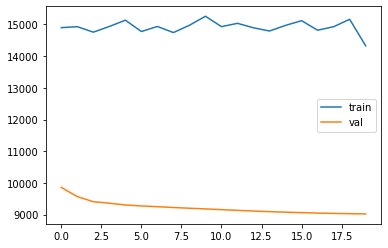

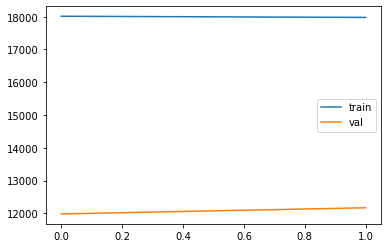

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot performance by epoch
plt.plot(fit_treat.epoch,fit_treat.history['mean_squared_error'])
plt.plot(fit_treat.epoch,fit_treat.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.plot(fit_control.epoch,fit_control.history['mean_squared_error'])
plt.plot(fit_control.epoch,fit_control.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()

In [13]:
# build MLP models with at least 2 hidden layers, ReLU activation, batch normalization, dropout
model_treat2 = keras.models.Sequential()
model_control2 = keras.models.Sequential()

model_treat2 = keras.models.Sequential()
model_treat2.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_treat2.add(keras.layers.Dense(25, activation="relu"))
model_treat2.add(keras.layers.Dense(10, activation="relu"))
model_treat2.add(keras.layers.Dense(1))


model_control2 = keras.models.Sequential()
model_control2.add(keras.layers.Dense(50, input_dim = len(covariates), activation="relu"))
model_control2.add(keras.layers.Dense(25, activation="relu"))
model_control2.add(keras.layers.Dense(10, activation="relu"))
model_control2.add(keras.layers.Dense(1))

model_treat2.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])
model_control2.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

from sklearn.model_selection import train_test_split

print("Treatment Dataset")

fit_treat2 = model_treat2.fit(Xt_train, yt_train, epochs=20, validation_split=0.2, callbacks=[es])

print(" ")
print("Control Dataset")


fit_control2 = model_control2.fit(Xc_train, yc_train, epochs=20, validation_split=0.2, callbacks=[es])

Treatment Dataset
Epoch 1/20
3/3 [==============================] - 0s 31ms/step - loss: 14491.6865 - mean_squared_error: 14491.6865 - val_loss: 8209.9072 - val_mean_squared_error: 8209.9072
Epoch 2/20
3/3 [==============================] - 0s 5ms/step - loss: 13551.2236 - mean_squared_error: 13551.2236 - val_loss: 7706.2905 - val_mean_squared_error: 7706.2905
Epoch 3/20
3/3 [==============================] - 0s 5ms/step - loss: 12802.7402 - mean_squared_error: 12802.7402 - val_loss: 7334.9819 - val_mean_squared_error: 7334.9819
Epoch 4/20
3/3 [==============================] - 0s 5ms/step - loss: 12303.3193 - mean_squared_error: 12303.3193 - val_loss: 7062.8604 - val_mean_squared_error: 7062.8604
Epoch 5/20
3/3 [==============================] - 0s 5ms/step - loss: 11921.3730 - mean_squared_error: 11921.3730 - val_loss: 6888.8452 - val_mean_squared_error: 6888.8452
Epoch 6/20
3/3 [==============================] - 0s 5ms/step - loss: 11605.3389 - mean_squared_error: 11605.3389 - val_l

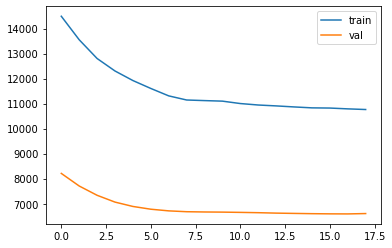

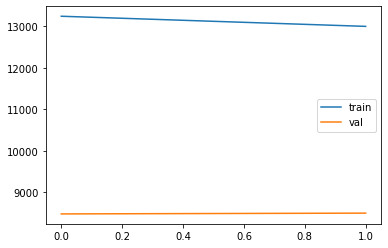

In [14]:
plt.plot(fit_treat2.epoch,fit_treat2.history['mean_squared_error'])
plt.plot(fit_treat2.epoch,fit_treat2.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.plot(fit_control2.epoch,fit_control2.history['mean_squared_error'])
plt.plot(fit_control2.epoch,fit_control2.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')
plt.show()

### Form predicted outcomes for each data point, using both `model_treat` and `model_control`.

In [15]:
test_set = Xt_test.append(Xc_test) 

y_pred_treat = model_treat.predict(test_set)
y_pred_control = model_control.predict(test_set)

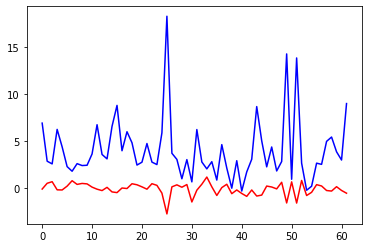

In [16]:
import numpy as np
x = np.arange(0, len(test_set))
plt.plot(x, y_pred_treat, 'r', x, y_pred_control, 'b')
plt.show()

### Find the 3 individuals that are most and least responsive to treatment and `describe` their covariates.

In [92]:
test_set['treat_effect'] = y_pred_treat - y_pred_control
test_set = test_set.sort_values('treat_effect', axis=0)
most_least_treat = test_set[:3].append(test_set[-3:])
most_least_treat

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,treat_effect
151,1.0,1.0,24.0,3.0,558.0,2.000000,40.0,33.0,1.0,-6.857453
480,0.0,1.0,18.0,3.0,420.0,1.799999,30.0,33.0,0.0,-5.081882
276,1.0,1.0,22.0,4.0,420.0,1.428571,32.0,47.0,1.0,-5.077276
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0,-0.433623
85,1.0,1.0,23.0,3.0,124.0,3.375000,42.0,33.0,0.0,-0.200371
286,1.0,0.0,24.0,1.0,43.0,0.375000,19.0,20.0,1.0,-0.132529


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

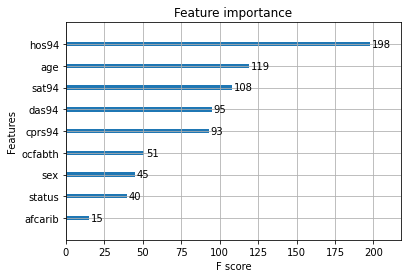

In [101]:
from xgboost import XGBRegressor
from xgboost import plot_importance

xgb = XGBRegressor()
xgb.fit(test_set[covariates], test_set['treat_effect'])

plot_importance(xgb)